In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
try:
    import simpleaudio as sa
except:
    %pip install simpleaudio
    import simpleaudio as sa
from IPython.display import Audio
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# calculate note frequencies
A_freq = 440
Csh_freq = A_freq * 2 ** (4 / 12)
E_freq = A_freq * 2 ** (7 / 12)

c = 255/np.log(255)

# get timesteps for each sample, T is note duration in seconds
sample_rate = 44100
T = 1
interval = int(sample_rate*T)
t = np.linspace(0, T, interval, False)

# generate sine wave notes
'''def generate_sound(rgb):
    sin_scal = t * 2 * np.pi
    amp_scal = 1/np.log(rgb[0] + rgb[1] + rgb[2])

    def generate_sins(R,G,B):
        R_1 = R*np.sin(A_freq   * sin_scal)
        G_1 = G*np.sin(Csh_freq * sin_scal)
        B_1 = B*np.sin(E_freq   * sin_scal)
        rv = R_1 + G_1 + B_1
        rv*= amp_scal
        return rv

    LOC_WHITE = generate_sins(255,255,255)

    out = generate_sins(rgb[0], rgb[1], rgb[2])
    
    # normalize to 16-bit range
    out*= 32767 / np.max(np.abs(LOC_WHITE))
    return out'''

def generate_sound(rgb):
    sin_scal = t * 2 * np.pi

    def generate_sins(R,G,B):
        R_1 = R*np.sin(A_freq   * sin_scal)
        G_1 = G*np.sin(Csh_freq * sin_scal)
        B_1 = B*np.sin(E_freq   * sin_scal)
        return R_1 + G_1 + B_1
    
    LOC_WHITE = generate_sins(255,255,255)

    out = generate_sins(rgb[0], rgb[1], rgb[2])
    
    # normalize to 16-bit range
    out*= 32767 / np.max(np.abs(LOC_WHITE))
    return out



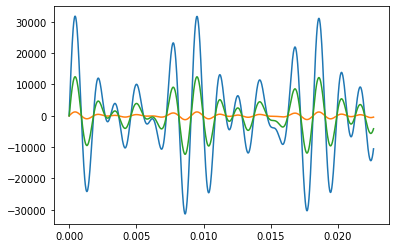

In [19]:
plt.plot(t[:1000], generate_sound(255,255,255)[:1000])
plt.plot(t[:1000], generate_sound(10,10,10)[:1000])
plt.plot(t[:1000], generate_sound(100,100,100)[:1000])
plt.show()

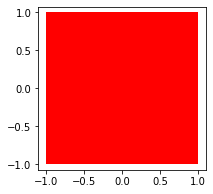

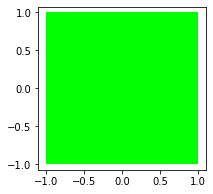

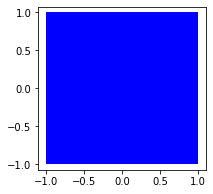

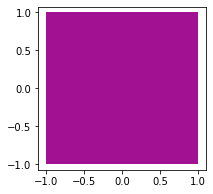

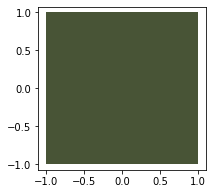

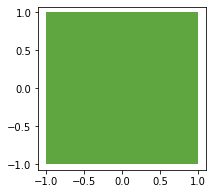

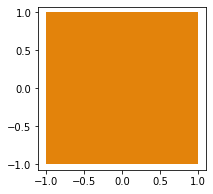

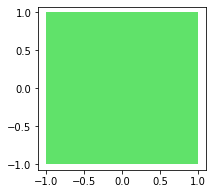

In [3]:
def generate_random_color():
    return np.random.randint(256, size=3)

def plot_colored_square(rgb):
    '''for i in range(len(rgb)):
        rgb[i] = rgb[i]/255'''
    col = colors.to_hex(rgb/255)
    x,y = [-1,1,1,-1],[-1,-1,1,1]
    plt.figure(figsize=(3,3))
    plt.axis('equal')
    plt.fill(x, y, col)
    plt.show()

def generate_samples(color_list):
    for c in color_list:
        plot_colored_square(c)
        display(Audio(data = generate_sound(c), rate = sample_rate))
    
color_list = [np.array([255,0,0]), np.array([0,255,0]), np.array([0,0,255])]
for i in range(5):
    color_list.append(generate_random_color())
generate_samples(color_list)



In [10]:
def generate_n_pickers(n):
    #returns np array of N color pickers
    rv = np.array([])
    for i in range(n):
        cp = widgets.ColorPicker(
        concise=True,
        description='Pick a color',
        value='white',
        disabled=False
        )
        rv = np.append(rv, cp)
    return rv

def generate_n_buttons(n):
    #returns np array of N confirmation buttons
    rv = np.array([])
    for i in range(n):
        b = widgets.Button(
        value=False,
        description='Confirm',
        disabled=False,
        tooltip=str(i),
        icon='check'
        )
        rv = np.append(rv, b)
    return rv

def generate_n_colors(n):
    #returns np array of N random colors
    rv = np.array([generate_random_color()])
    for i in range(1,n):
        rv = np.append(rv, [generate_random_color()], axis = 0)
    return rv

def generate_n_sounds(n):
    #returns np array of N sounds from N randomly generated colors, as well as this np array of colors
    rv = np.array([])
    col = generate_n_colors(n)
    for c in col:
        a = Audio(data = generate_sound(c), rate = sample_rate)
        rv = np.append(rv, a)
    return rv, col

N = 5
pickers = generate_n_pickers(N)
buttons = generate_n_buttons(N)
sounds, targets = generate_n_sounds(N)

for i in range(N):
    display(sounds[i], pickers[i], buttons[i])

def on_button_clicked(b):
    #create individual on_button_clicked functions for each button, tying it to corresponding cp
    i = int(b.tooltip)
    pickers[i].disabled = True
    b.disabled = True

for b in buttons:
    b.on_click(on_button_clicked)



ColorPicker(value='white', concise=True, description='Pick a color')

Button(description='Confirm', icon='check', style=ButtonStyle(), tooltip='0')

ColorPicker(value='white', concise=True, description='Pick a color')

Button(description='Confirm', icon='check', style=ButtonStyle(), tooltip='1')

ColorPicker(value='white', concise=True, description='Pick a color')

Button(description='Confirm', icon='check', style=ButtonStyle(), tooltip='2')

ColorPicker(value='white', concise=True, description='Pick a color')

Button(description='Confirm', icon='check', style=ButtonStyle(), tooltip='3')

ColorPicker(value='white', concise=True, description='Pick a color')

Button(description='Confirm', icon='check', style=ButtonStyle(), tooltip='4')

In [5]:
guesses = np.array([np.array(colors.to_rgb(pickers[0].value)) * 255])
for i in range(1,N):
    c = np.array(colors.to_rgb(pickers[i].value)) * 255
    guesses = np.append(guesses, [c], axis = 0)

differences = guesses - targets
distances = np.linalg.norm(differences, axis = 1)
distances

array([167.4126638 , 156.35856229, 200.3746491 , 180.11662888,
       260.31903503])

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_6997/562025436.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


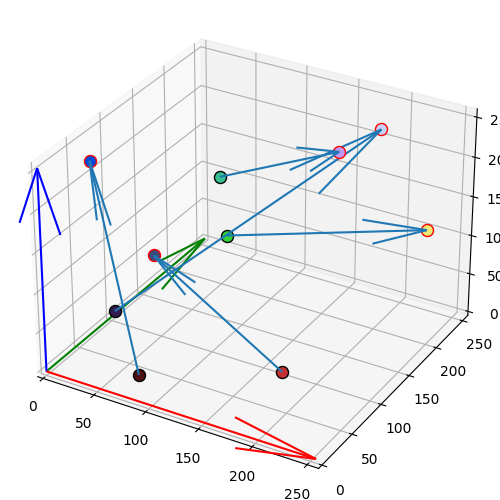

In [11]:
%matplotlib widget

fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)

ax.set_xlim(0,255)
ax.set_ylim(0,255)
ax.set_zlim(0,255)

#Plot red, green, and blue axes as vectors.
ax.quiver(0,0,0,255,0,0, color = 'r')
ax.quiver(0,0,0,0,255,0, color = 'g')
ax.quiver(0,0,0,0,0,255, color = 'b')

for i in range(N):
    g = guesses[i]
    t = targets[i]
    cg = colors.to_hex(g/255)
    ct = colors.to_hex(t/255)
    ax.scatter(g[0], g[1], g[2], c = cg, edgecolors = 'black', s=75, linewidth = 1)
    ax.scatter(t[0], t[1], t[2], c = ct, edgecolors = 'red', s=75, linewidth = 1)
    ax.quiver(g[0], g[1], g[2], t[0] - g[0], t[1] - g[1], t[2] - g[2])
